# ANALYSIS FILE
All processing is done in MAIN.ipynb. Here is just visualisation and fluff

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import util.validation_testing as val

import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm


import matplotlib.gridspec as gridspec
import util.correlation_measure as cm
import util.visualisation as vis

In [2]:
########################### EDITABLE SPACE #########################################
ANALYSIS_FILENAME = 'results/NEM excl/crqa_NEM-'
#ANALYSIS_FILENAME = 'results/factors'

RESPONSE_VARIABLE = 'score'
SAVE_FIG = True

####################################################################################

PHASES = ['instructional_video_0', 'discussion_phase_0', *[f'reschu_run_{i}' for i in range(4)], 'discussion_phase_1', *[f'reschu_run_{4+i}' for i in range(4)]]
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

FACTOR_LABELS = {
    'f1': "Enjoyment Smile",
    'f2': "Eyebrows Up",
    'f3': "Mouth Open",
    'f4': "Mouth Tightening",
    'f5': "Eye Tightening",
    'f6': "Mouth Frown"
}

AVAILABLE_PAIRS = ['05_06', '07_08', '09_10', '99_100', '101_102', '103_104', '13_14', '19_20', '21_22', '25_26', '27_28', '29_30', '31_32', '33_34', '35_36', '37_38', '39_40', '41_42', '43_44', '45_46', '47_48', '49_50', '51_52', '59_60', '61_62', '67_68', '69_70', '71_72', '73_74', '77_78', '79_80', '81_82', '83_84', '85_86', '87_88', '91_92', '93_94', '95_96', '97_98']

assert(len(AVAILABLE_PAIRS) == 39) # change if needed

# SCORES OUT OF RESCHU
scores = pd.read_csv('RESCHU-data/teamscores_allParticipants_filtered.csv')
scores = scores[['SubjectId', 'reschuRun', 'TeamTotal']]

RESCHU_DATA = {}
for pair in AVAILABLE_PAIRS:
    p1, _ = pair.split("_")
    df = scores[scores['SubjectId'] == int(p1)]
    score = [[df['reschuRun'].values[i], df['TeamTotal'].values[i]] for i in range(len(df))]
    RESCHU_DATA[pair] = {
        'score' : score,
        'zoom'  : (int(p1)-1)%4 < 2,
        'beeps' : [int(p1) % 4 == 1, int(p1) % 4 != 1] * 4
    }
RESCHU_DATA['51_52']['score'] = [[0, None]] + RESCHU_DATA['51_52']['score'] # because 51_52 misses the score for reschu_run_0

# print example RESCHU data
print(f'Example RESCHU data for pair 51_52: \nscore: {RESCHU_DATA['51_52']['score']}\nzoom: {RESCHU_DATA['51_52']['zoom']}\nbeeps: {RESCHU_DATA['51_52']['beeps']}')


Example RESCHU data for pair 51_52: 
score: [[0, None], [1, 5], [2, 1], [3, 10], [4, 3], [5, 11], [6, 8], [7, 12]]
zoom: False
beeps: [False, True, False, True, False, True, False, True]


# Demographics

In [3]:
pairs = []
for p in AVAILABLE_PAIRS:
    p1, p2 = p.split("_")
    pairs.append(int(p1))
    pairs.append(int(p2))

df = pd.read_csv("RESCHU-data/demographics.csv")
df = df[df['ParticipantID'].isin(pairs)]

assert(len(np.unique(df['ParticipantID'].values))== len(AVAILABLE_PAIRS)*2)
assert(len(np.unique(df['ParticipantID'].values)) == len((df['ParticipantID'].values)))

gender = []
for _, row in df.iterrows():
    if row['Gender'] == 2:
        gender.append("Male")
    else:
        gender.append("Female")
df['Gender'] = gender
print(df['Gender'].value_counts())
print(df['Age'].value_counts())

Gender
Female    54
Male      24
Name: count, dtype: int64
Age
19    19
20    13
22    11
18    11
21     5
23     4
24     3
25     3
26     2
36     1
33     1
39     1
17     1
32     1
48     1
29     1
Name: count, dtype: int64


# Visualisation 

## NEM incl / excl

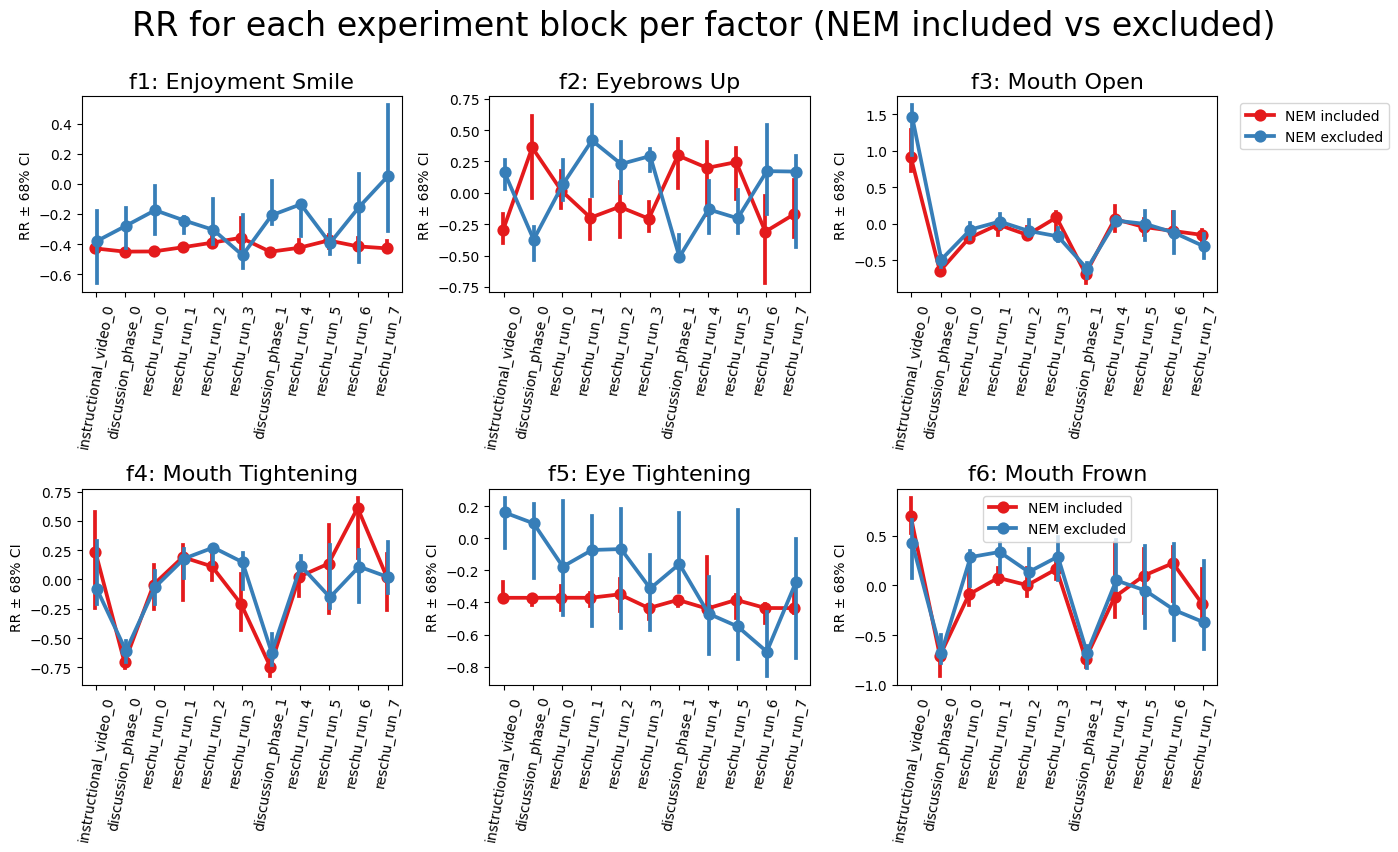

In [4]:
df_incl = pd.read_csv(r'results/NEM incl/crqa_NEM+_overall_questionnaire.csv')
df_excl = pd.read_csv(r'results/NEM excl/crqa_NEM-_overall_questionnaire.csv')

for f in FACTORS:
    df_incl[f] = (df_incl[f] - df_incl[f].mean()) / df_incl[f].std()
    df_excl[f] = (df_excl[f] - df_excl[f].mean()) / df_excl[f].std()
    
# Assume df_incl and df_excl are your two datasets
df_incl['condition'] = 'NEM included'
df_excl['condition'] = 'NEM excluded'

# Combine datasets
df_combined = pd.concat([df_incl, df_excl], ignore_index=True)

# Filter and order phases
df_combined = df_combined[df_combined['phase'].isin(PHASES)].copy()
df_combined['phase_ord'] = pd.Categorical(
    df_combined['phase'],
    categories=PHASES,
    ordered=True
)
df_combined['phase_num'] = df_combined['phase_ord'].cat.codes + 1
df_combined = df_combined.reset_index(drop=True)

# Scale variables (independently per condition to preserve relative scaling)
for condition_label in df_combined['condition'].unique():
    condition_mask = df_combined['condition'] == condition_label
    for col in ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', RESPONSE_VARIABLE]:
        mean = df_combined.loc[condition_mask, col].mean()
        std = df_combined.loc[condition_mask, col].std()
        df_combined.loc[condition_mask, f'{col}_scaled'] = (
            df_combined.loc[condition_mask, col] - mean
        ) / std


plt.figure(figsize=(14, 8))
for i, factor in enumerate(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'], 1):
    plt.subplot(2, 3, i)

    sns.pointplot(
        data=df_combined,
        x='phase_ord',
        y=factor,
        hue='condition',
        estimator=np.median,
        errorbar=('ci', 68),
        dodge=True,
        palette='Set1'
    )

    plt.title(f'{factor}: {FACTOR_LABELS[factor]}', fontsize=16)
    plt.xticks(rotation=80)
    plt.xlabel('')
    plt.ylabel("RR ± 68% CI")
    if i == 3:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend().remove()

plt.tight_layout()
plt.legend(loc='upper center')

plt.suptitle("RR for each experiment block per factor (NEM included vs excluded)", fontsize=24, y=1.06)
if SAVE_FIG: plt.savefig("img/RR_block_NEM_compared.png", dpi='figure', bbox_inches='tight')
plt.show()


## Comparing RR and TP

In [5]:
df = pd.read_csv(f'{ANALYSIS_FILENAME}_overall_questionnaire.csv')
print(df.columns)
# Run tests for each dependent variable
for dep_var in ['score', 'Teamwork', 'Cohesion', 'Cooperation', 'Empathy']:
    print(f"\n{'-'*20}\n{dep_var.upper()}\n{'-'*20}")
    avg_results, phase_results = val.run_significance_tests(df, dep_var)
    
    print("Average:")
    print(avg_results)
    print("\nExcluding intro + discussion. \nInspecting phases individually:")
    print(phase_results)

Index(['Unnamed: 0', 'pair', 'zoom', 'phase', 'beeps', 'score', 'f1', 'f2',
       'f3', 'f4', 'f5', 'f6', 'Teamwork', 'Cohesion', 'Cooperation',
       'Empathy'],
      dtype='object')

--------------------
SCORE
--------------------
Average:
Empty DataFrame
Columns: [setting, component, rho, p]
Index: []

Excluding intro + discussion. 
Inspecting phases individually:
        setting component       rho         p
0    all_reschu        f3  0.272372  0.000019
1    all_reschu        f4  0.127669  0.048199
2    all_reschu        f5 -0.145122  0.024551
3   zoom = True        f3  0.264897  0.002832
4   zoom = True        f5 -0.215159  0.015967
5  zoom = False        f3  0.270370  0.003474
6  reschu_run_0        f5 -0.326723  0.045274
7  reschu_run_1        f3  0.477235  0.002448
8  reschu_run_2        f3  0.489930  0.001546
9  reschu_run_4        f6  0.458405  0.016183

--------------------
TEAMWORK
--------------------
Average:
Empty DataFrame
Columns: [setting, component, rho, p]
Index:

In [6]:
df = pd.read_csv(f'{ANALYSIS_FILENAME}_overall_questionnaire.csv')
print(np.unique(df['phase'].values))
zoom_new = []
for _, row in df.iterrows():
    zoom_new.append(RESCHU_DATA[row['pair']]['zoom'])
df['zoom'] = zoom_new
df.head()

['discussion_phase_0' 'discussion_phase_1' 'instructional_video_0'
 'reschu_run_0' 'reschu_run_1' 'reschu_run_2' 'reschu_run_3'
 'reschu_run_4' 'reschu_run_5' 'reschu_run_6' 'reschu_run_7']


,Unnamed: 0,pair,zoom,phase,beeps,score,f1,f2,f3,f4,f5,f6,Teamwork,Cohesion,Cooperation,Empathy
0,0,05_06,True,discussion_phase_0,NaN,NaN,0.0187,0.0313,0.0344,0.0295,0.0002,0.0343,NaN,5.6,7.222222,9.956522
1,1,05_06,True,reschu_run_0,True,4.0,0.0288,0.0479,0.0452,0.0491,0.0026,0.0406,184.0,5.6,7.222222,9.956522
2,2,05_06,True,reschu_run_1,False,11.0,0.0298,0.0418,0.0457,0.0521,0.0006,0.0413,200.0,5.6,7.222222,9.956522
3,3,05_06,True,reschu_run_2,True,23.0,0.0347,0.0454,0.0449,0.0404,0.0015,0.0327,200.0,5.6,7.222222,9.956522
4,4,05_06,True,reschu_run_3,False,21.0,0.0098,0.0508,0.0502,0.0452,0.0000,0.0322,200.0,5.6,7.222222,9.956522


### Plotting

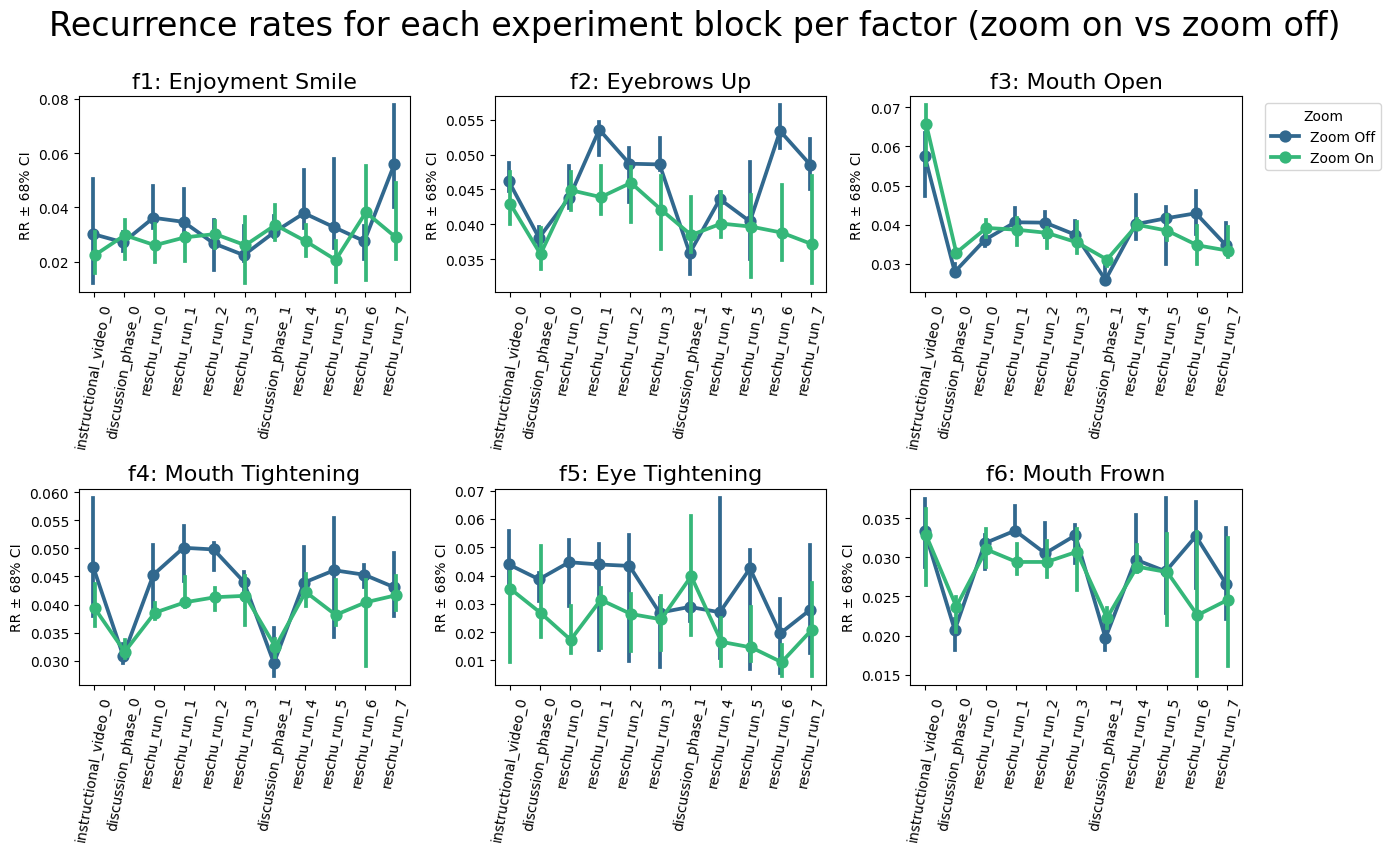

In [7]:
# Filter and order phases
full_df = df[df['phase'].isin(PHASES)].copy()
full_df['phase_ord'] = pd.Categorical(
    full_df['phase'],
    categories=PHASES,
    ordered=True
)
full_df['phase_num'] = full_df['phase_ord'].cat.codes + 1
full_df = full_df.reset_index(drop=True)

# Scale variables
for col in ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', RESPONSE_VARIABLE]:
    full_df[f'{col}_scaled'] = (full_df[col] - full_df[col].mean()) / full_df[col].std()

plt.figure(figsize=(14, 8))
for i, factor in enumerate(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'], 1):
    plt.subplot(2, 3, i)
    
    sns.pointplot(
        data=full_df,
        x='phase_ord',
        y=factor,
        hue='zoom',
        estimator=np.median,
        errorbar=('ci', 68),
        palette='viridis',
        dodge=True
    )
    
    plt.title(f'{factor}: {FACTOR_LABELS[factor]}', fontsize=16)
    plt.xticks(rotation=80)
    plt.xlabel('')
    plt.ylabel("RR ± 68% CI")
    if i == 3:
        handles, labels = plt.gca().get_legend_handles_labels()
        custom_labels = ['Zoom Off', 'Zoom On']  # Adjust as needed
        plt.legend(handles, custom_labels, title='Zoom', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend().remove()

plt.tight_layout()
plt.suptitle("Recurrence rates for each experiment block per factor (zoom on vs zoom off)", fontsize=24, y=1.06)
if SAVE_FIG: plt.savefig("img/FACE_per_phase.png", dpi='figure', bbox_inches='tight')
plt.show()


In [8]:
# =====================================================================
# 2. Mixed-Effects Models (All Phase Effects)
# =====================================================================

all_results = []

if 'pair' not in full_df.columns:
    raise ValueError("Missing 'pair' column in your dataframe.")

for factor in ['f1_scaled', 'f2_scaled', 'f3_scaled', 'f4_scaled', 'f5_scaled', 'f6_scaled']:
    formula = f"{factor} ~ phase_ord * zoom"
    try:
        model = mixedlm(formula, data=full_df, groups=full_df["pair"])
        fit = model.fit()

        # Extract coefficients and p-values
        coef_table = pd.DataFrame({
            'term': fit.params.index,
            'coef': fit.params.values,
            'pval': fit.pvalues.values
        })

        # Filter only phase and interaction terms
        phase_terms = coef_table[coef_table['term'].str.startswith('phase_ord')]
        phase_terms['factor'] = factor

        all_results.append(phase_terms)

    except Exception as e:
        print(f"Error fitting model for {factor}: {e}")

# Combine results
if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    print("\nMixed-Effects Coefficients by Phase:")
    print(combined_results[['factor', 'term', 'coef', 'pval']])
    print(combined_results[combined_results['pval'] < 0.05])
else:
    print("No model results were collected.")

C:\Users\Erik\AppData\Local\Temp\ipykernel_22080\3533597987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_terms['factor'] = factor
C:\Users\Erik\AppData\Local\Temp\ipykernel_22080\3533597987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_terms['factor'] = factor
C:\Users\Erik\AppData\Local\Temp\ipykernel_22080\3533597987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 


Mixed-Effects Coefficients by Phase:
        factor                                          term      coef  \
0    f1_scaled               phase_ord[T.discussion_phase_0] -0.368429   
1    f1_scaled                     phase_ord[T.reschu_run_0] -0.031070   
2    f1_scaled                     phase_ord[T.reschu_run_1] -0.014603   
3    f1_scaled                     phase_ord[T.reschu_run_2] -0.161845   
4    f1_scaled                     phase_ord[T.reschu_run_3] -0.085534   
..         ...                                           ...       ...   
115  f6_scaled  phase_ord[T.discussion_phase_1]:zoom[T.True]  0.252502   
116  f6_scaled        phase_ord[T.reschu_run_4]:zoom[T.True] -0.278748   
117  f6_scaled        phase_ord[T.reschu_run_5]:zoom[T.True] -0.488650   
118  f6_scaled        phase_ord[T.reschu_run_6]:zoom[T.True] -1.081492   
119  f6_scaled        phase_ord[T.reschu_run_7]:zoom[T.True] -0.590594   

         pval  
0    0.070114  
1    0.876808  
2    0.941918  
3    0.41

In [9]:
RESPONSE_VARIABLE = 'score'

f1: coef = 0.0031, p = 0.9727
f2: coef = 0.0325, p = 0.6416
f3: coef = 0.2631, p = 0.0001617
f4: coef = 0.1579, p = 0.03064
f5: coef = -0.0914, p = 0.2748
f6: coef = 0.0999, p = 0.1726


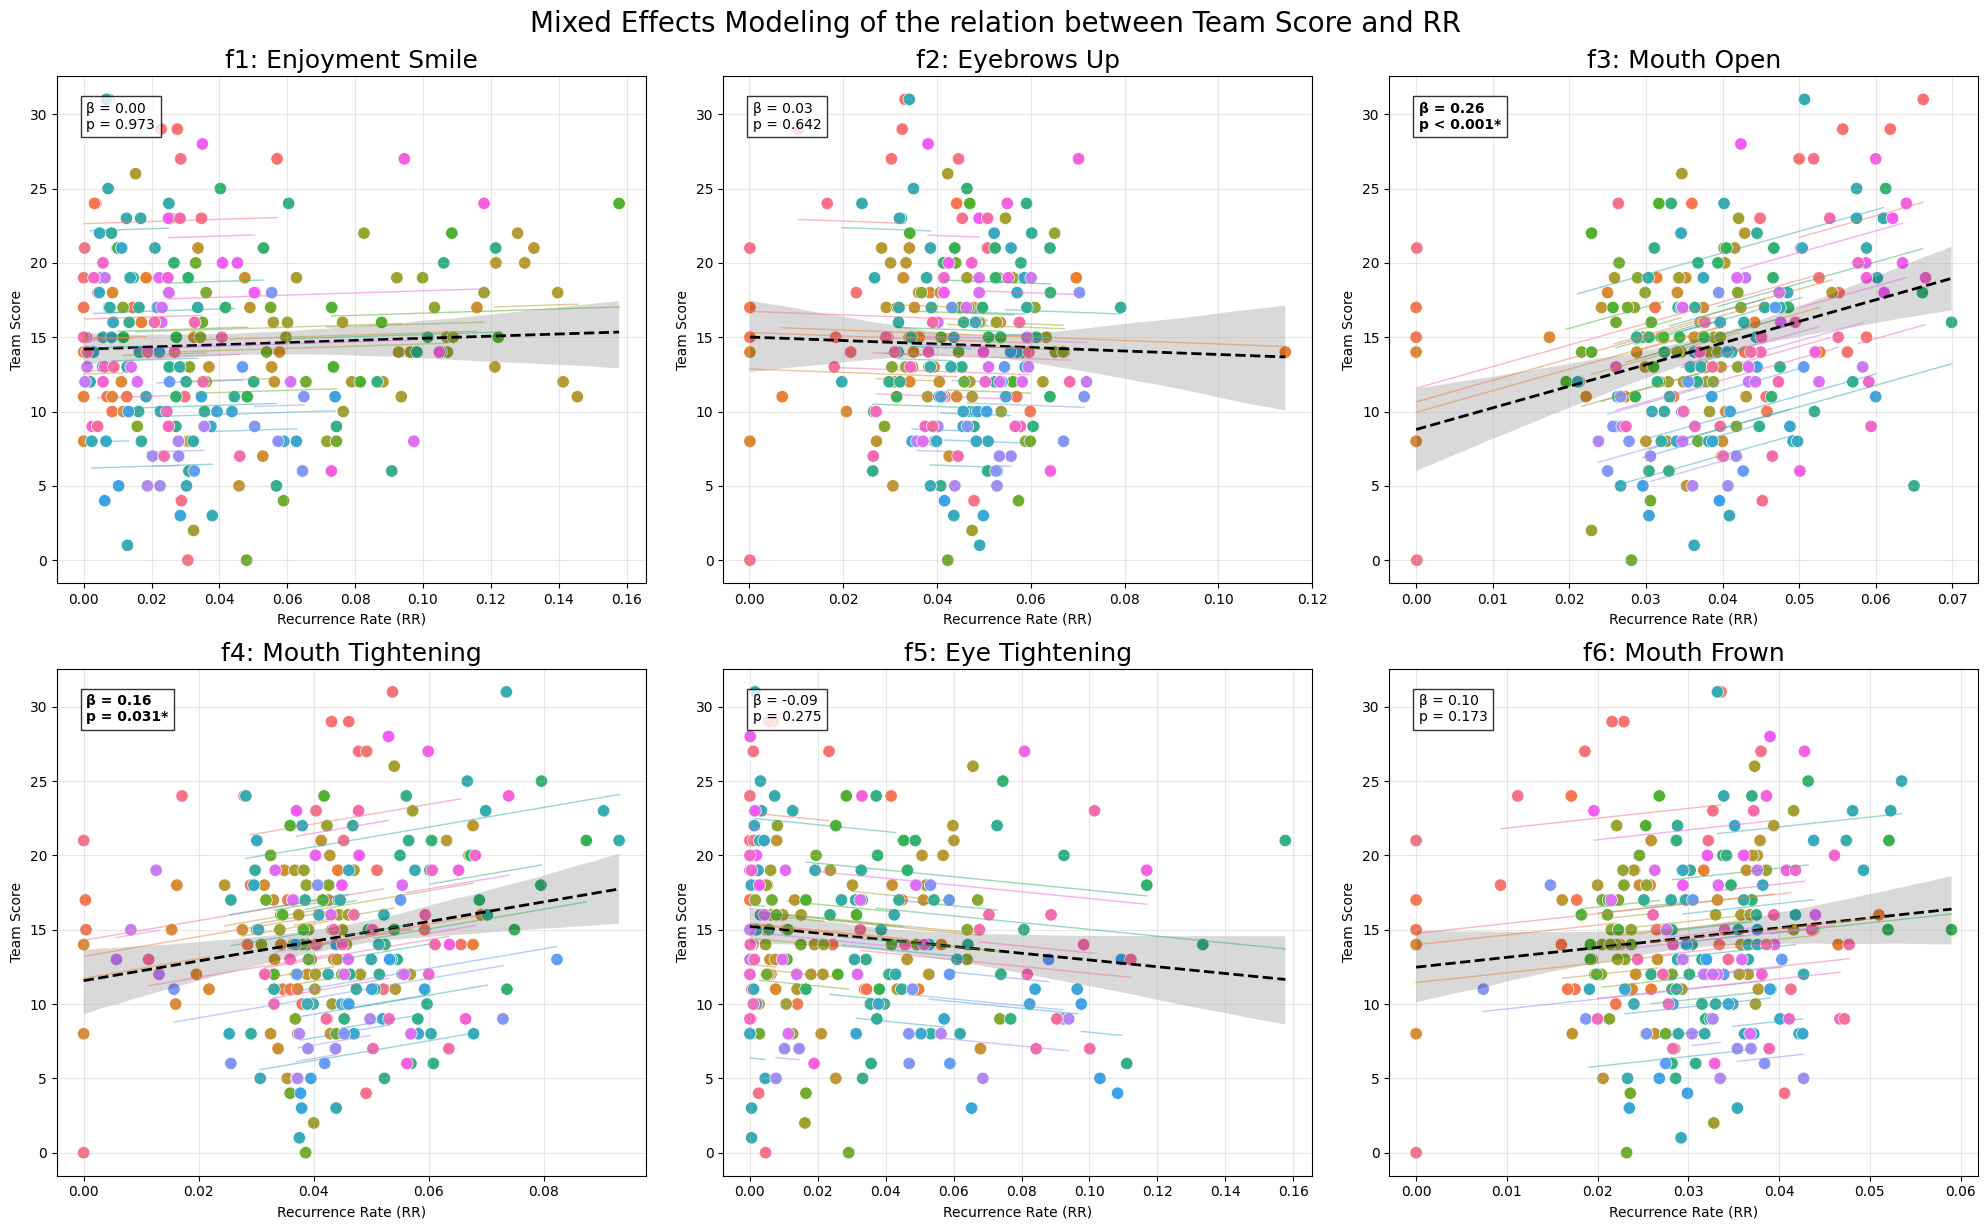

,factor,coef,pval
0,f1,0.003070,0.972745
1,f2,0.032519,0.641611
2,f3,0.263098,0.000162
3,f4,0.157859,0.030643
4,f5,-0.091412,0.274780
5,f6,0.099850,0.172596


In [10]:
vis.unified_rr_tp_analysis(df, RESPONSE_VARIABLE, save_fig=SAVE_FIG)


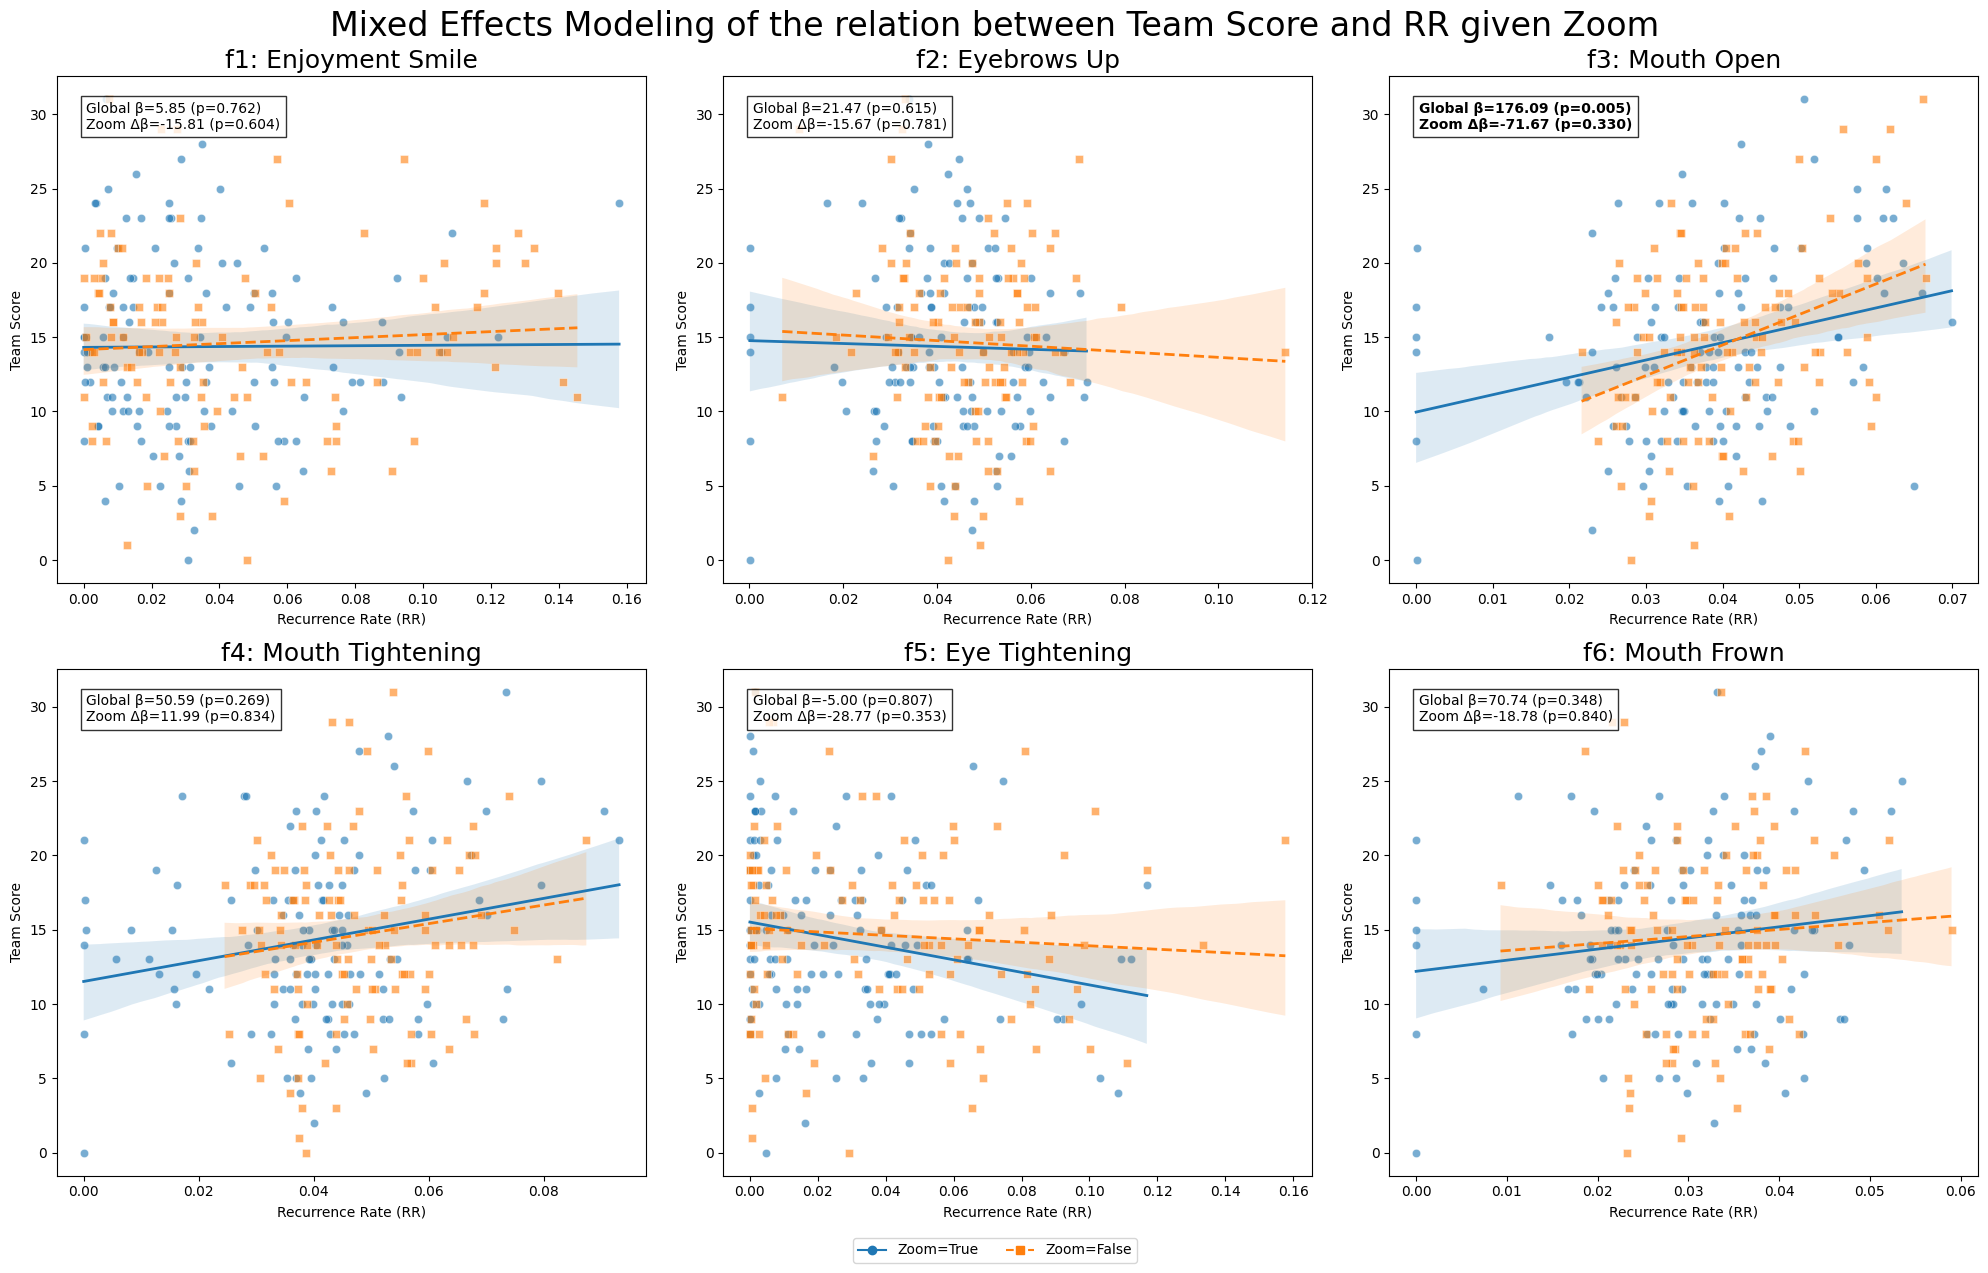

,factor,global_slope,global_p,zoom_slope,zoom_p
0,f1,5.853176,0.762240,-15.810202,0.604201
1,f2,21.472151,0.614906,-15.666994,0.781227
2,f3,176.091794,0.004949,-71.668131,0.329988
3,f4,50.590292,0.269154,11.988007,0.834065
4,f5,-4.995764,0.807112,-28.772633,0.352773
5,f6,70.737956,0.347578,-18.775936,0.839656


In [11]:
vis.unified_mixed_model_analysis(df, RESPONSE_VARIABLE, save_fig=SAVE_FIG)

In [12]:
assert(True == False)

AssertionError: 

### Check distributions

In [ ]:
# Prepare data - Only RESCHU phases
reschu_df = df[df['phase'].str.contains('reschu_run')].copy()
factors = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
reschu_df = reschu_df.dropna(subset=[RESPONSE_VARIABLE])

# 1. Standardization
for factor in factors + [RESPONSE_VARIABLE]:
    reschu_df[f'{factor}_std'] = (reschu_df[factor] - reschu_df[factor].mean()) / reschu_df[factor].std()

# 2. Mixed-effects modeling with random intercepts
results = []
model_outputs = {}

for factor in factors:
    formula = f"{RESPONSE_VARIABLE}_std ~ {factor}_std * zoom"
    model = smf.mixedlm(
        formula,
        data=reschu_df,
        groups=reschu_df['pair'],
        re_formula='1'
    ).fit(reml=False)
    
    params = model.params
    pvals = model.pvalues
    results.append({
        'factor': factor,
        'zoom_slope': params.get(f'{factor}_std:zoom[T.True]', float('nan')),
        'zoom_p': pvals.get(f'{factor}_std:zoom[T.True]', float('nan')),
        'global_slope': params[f'{factor}_std'],
        'global_p': pvals[f'{factor}_std']
    })
    model_outputs[factor] = model

# 3. Results table
results_df = pd.DataFrame(results)
print("Mixed Model Results:")
print(results_df[['factor', 'global_slope', 'global_p', 'zoom_slope', 'zoom_p']])

# 4. Histograms of residuals
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, factor in enumerate(factors):
    model = model_outputs[factor]
    residuals = model.resid
    ax = axes[i]
    sns.histplot(residuals, kde=True, ax=ax, bins=30, color='steelblue')
    ax.set_title(f"{factor} - {FACTOR_LABELS[factor]}", fontsize = 16)
    ax.set_xlabel("Residuals")
    ax.set_xlim(-3, 3)

plt.tight_layout()
plt.suptitle("Residuals Distribution per Factor", fontsize=24, y=1.06)
if SAVE_FIG: plt.savefig("img/residuals.png", dpi='figure', bbox_inches='tight')
plt.show()

# 5. Residuals vs Fitted
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, factor in enumerate(factors):
    model = model_outputs[factor]
    fitted = model.fittedvalues
    residuals = model.resid
    ax = axes[i]
    ax.scatter(fitted, residuals, alpha=0.5)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f"{factor} - {FACTOR_LABELS[factor]}", fontsize = 16)
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")

plt.tight_layout()
plt.suptitle("Residuals vs Fitted Values per Factor", fontsize=24, y=1.06)
if SAVE_FIG: plt.savefig("img/resid_fitted.png", dpi='figure', bbox_inches='tight')
plt.show()


KeyError: 'phase'

# Illustrative examples

C:\Users\Erik\AppData\Local\Temp\ipykernel_17832\905441173.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


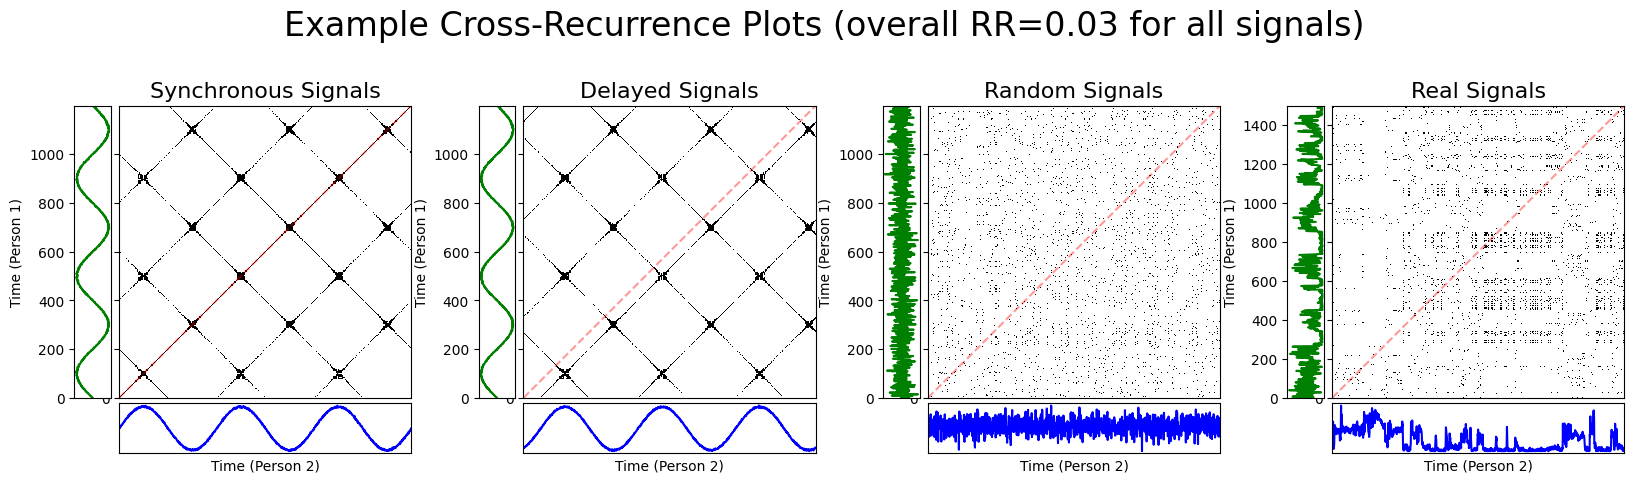

0.0302 0.0295 0.0296 0.0311


In [ ]:
fig = plt.figure(figsize=(20, 6))
outer = gridspec.GridSpec(1, 4, wspace=0.2)

# Generate shared time axis
np.random.seed(42)
duration_seconds = 120
sampling_rate = 60
n_samples = duration_seconds * sampling_rate
t = np.linspace(0, duration_seconds, n_samples, endpoint=False)

# Base signal and noise
signal = np.sin(0.5 * np.pi * 0.1 * t) + 5
noise = np.random.randn(n_samples) / 50


# 1. Synchronous
p1 = signal + noise
p2 = signal + noise
result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60, radius=0.022, remove_non_event_matches=True)
sync = result['RR']
vis.plot_crp_with_signals(p1[::6], p2[::6], result['recurrence'], title="Synchronous Signals", fig=fig, outer_grid=outer[0])

# 2. Delayed
delay_seconds = 7
p1 = np.sin(0.5 * np.pi * 0.1 * (t)) + noise
p2 = np.sin(0.5 * np.pi * 0.1 * (t - delay_seconds)) + noise
result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60, radius=0.022, remove_non_event_matches=True)
mim = result['RR']
vis.plot_crp_with_signals(p1[::6], p2[::6], result['recurrence'], title="Delayed Signals", fig=fig, outer_grid=outer[1])

# 3. Random
p1 = np.random.randn(len(t))
p2 = np.random.randn(len(t))
result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60, radius=0.028, remove_non_event_matches=True)
vis.plot_crp_with_signals(p1[::6], p2[::6], result['recurrence'], title="Random Signals", fig=fig, outer_grid=outer[2])
ran = result['RR']

import pandas as pd
p1 = pd.read_csv(r"data\39_40\features\pp39_reschu_run_4_factors.csv")['f3'].values
p2 = pd.read_csv(r"data\39_40\features\pp40_reschu_run_4_factors.csv")['f3'].values


result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60, radius=0.05, remove_non_event_matches=True)
real= result['RR']
vis.plot_crp_with_signals(p1[::6], p2[::6], result['recurrence'], title="Real Signals", fig=fig, outer_grid=outer[3])
plt.tight_layout()
plt.suptitle("Example Cross-Recurrence Plots (overall RR=0.03 for all signals)", fontsize=24, y=0.95)
if SAVE_FIG: plt.savefig(f"img/ILLUSTRATIVE.png", dpi='figure', bbox_inches='tight')
plt.show()

print(sync, mim, ran, real)
